## Import Necessary Libraries

In [1]:
import re
import nltk
import gensim
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from gensim import corpora
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool
from nltk.corpus import stopwords
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from gensim.models.ldamodel import LdaModel
from nltk.sentiment import SentimentIntensityAnalyzer

## Loading data

In [2]:
file_path = 'Tweets_with_location.csv'

# Attempting to read the file with a different encoding
try:
    tweets_df = pd.read_csv(file_path, encoding='ISO-8859-1')
except Exception as e:
    error = str(e)

# Check if the file was successfully read or report the error
if 'tweets_df' in locals():
    success = True
    preview = tweets_df.head()
else:
    success = False
    preview = error

#success, preview

# Display the first few rows of the dataframe
tweets_df.head()

,Name,UserName,Time,Text,Likes,Retweets,TweetURL,UserURL,City,Country,Unnamed: 10,Unnamed: 11
0,Gerald Butts,gmbutts,1/24/2022 22:24,I'm glad serious researchers are taking up thi...,17.0,50.0,https://twitter.com/gmbutts/status/14857402380...,https://twitter.com/gmbutts,0,0,NaN,NaN
1,Gerald Butts,gmbutts,1/24/2022 22:27,1. Partisan adhesion in Canada is weak and par...,2.0,31.0,https://twitter.com/gmbutts/status/14857409939...,https://twitter.com/gmbutts,0,0,NaN,NaN
2,Abigail Boyd,AbigailBoydMLC,3/7/2022 23:46,"Minister Ayers, what are you doing to assist t...",8.0,12.0,https://twitter.com/AbigailBoydMLC/status/1500...,https://twitter.com/AbigailBoydMLC,0,0,NaN,NaN
3,Warren Gunnels,GunnelsWarren,2/22/2022 23:49,I want cable news to cover the child poverty r...,5418.0,203000.0,https://twitter.com/GunnelsWarren/status/14962...,https://twitter.com/GunnelsWarren,0,0,NaN,NaN
4,Scalawag,scalawagmag,3/21/2022 21:45,"""If we don't adapt the internet to the reality...",1.0,9.0,https://twitter.com/scalawagmag/status/1506024...,https://twitter.com/scalawagmag,0,0,NaN,NaN


## Data cleaning

In [3]:
def remove_irrelevant_columns(df, columns_to_remove):
    """Remove irrelevant columns from the dataframe."""
    df = df.drop(columns=columns_to_remove, errors='ignore')
    return df

def handle_missing_values(df, columns):
    """Handle missing or placeholder values in specified columns."""
    for column in columns:
        # Assuming '0' is a placeholder for missing data
        df[column] = df[column].replace('0', None)
    return df

def convert_to_datetime(df, column):
    """Convert a column to datetime format."""
    df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

def clean_text_data(df, text_column):
    """Clean the text data in a specified column."""
    def clean_text(text):
        if not isinstance(text, str):
            return text  # Return the original value if it's not a string
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^A-Za-z ]+', '', text)
        return text.strip()

    df[text_column] = df[text_column].apply(clean_text)
    return df

# Applying the functions to the dataset
tweets_cleaned = tweets_df.copy()
tweets_cleaned = remove_irrelevant_columns(tweets_cleaned, ['Unnamed: 10', 'Unnamed: 11'])
tweets_cleaned = handle_missing_values(tweets_cleaned, ['City', 'Country'])
tweets_cleaned = convert_to_datetime(tweets_cleaned, 'Time')
tweets_cleaned = clean_text_data(tweets_cleaned, 'Text')

# Displaying the first few rows of the cleaned dataframe
tweets_cleaned.head()

,Name,UserName,Time,Text,Likes,Retweets,TweetURL,UserURL,City,Country
0,Gerald Butts,gmbutts,2022-01-24 22:24:00,Im glad serious researchers are taking up this...,17.0,50.0,https://twitter.com/gmbutts/status/14857402380...,https://twitter.com/gmbutts,None,None
1,Gerald Butts,gmbutts,2022-01-24 22:27:00,Partisan adhesion in Canada is weak and partly...,2.0,31.0,https://twitter.com/gmbutts/status/14857409939...,https://twitter.com/gmbutts,None,None
2,Abigail Boyd,AbigailBoydMLC,2022-03-07 23:46:00,Minister Ayers what are you doing to assist th...,8.0,12.0,https://twitter.com/AbigailBoydMLC/status/1500...,https://twitter.com/AbigailBoydMLC,None,None
3,Warren Gunnels,GunnelsWarren,2022-02-22 23:49:00,I want cable news to cover the child poverty r...,5418.0,203000.0,https://twitter.com/GunnelsWarren/status/14962...,https://twitter.com/GunnelsWarren,None,None
4,Scalawag,scalawagmag,2022-03-21 21:45:00,If we dont adapt the internet to the reality o...,1.0,9.0,https://twitter.com/scalawagmag/status/1506024...,https://twitter.com/scalawagmag,None,None


## Basic Analysis

In [4]:
# Basic Statistics
num_tweets = tweets_cleaned.shape[0]
num_unique_users = tweets_cleaned['UserName'].nunique()
most_active_users = tweets_cleaned['UserName'].value_counts().head(5)
most_liked_tweet = tweets_cleaned.loc[tweets_cleaned['Likes'].idxmax()]
most_retweeted_tweet = tweets_cleaned.loc[tweets_cleaned['Retweets'].idxmax()]

basic_statistics = {
    "Number of Tweets": num_tweets,
    "Number of Unique Users": num_unique_users,
    "Most Active Users": most_active_users,
    "Most Liked Tweet": most_liked_tweet[['UserName', 'Text', 'Likes']],
    "Most Retweeted Tweet": most_retweeted_tweet[['UserName', 'Text', 'Retweets']]
}

basic_statistics

{'Number of Tweets': 10814,
 'Number of Unique Users': 8169,
 'Most Active Users': PCarterClimate    65
 insideclimate     36
 bobhillbrain      34
 ECOWARRIORSS      34
 climatecouncil    31
 Name: UserName, dtype: int64,
 'Most Liked Tweet': UserName                                           WhipRealer
 Text        Its a farce Always has been Always will be Cli...
 Likes                                                213000.0
 Name: 9414, dtype: object,
 'Most Retweeted Tweet': UserName                                                POTUS
 Text        Congratulations to EmmanuelMacron on his reele...
 Retweets                                            1505000.0
 Name: 5580, dtype: object}

## Temporal analysis

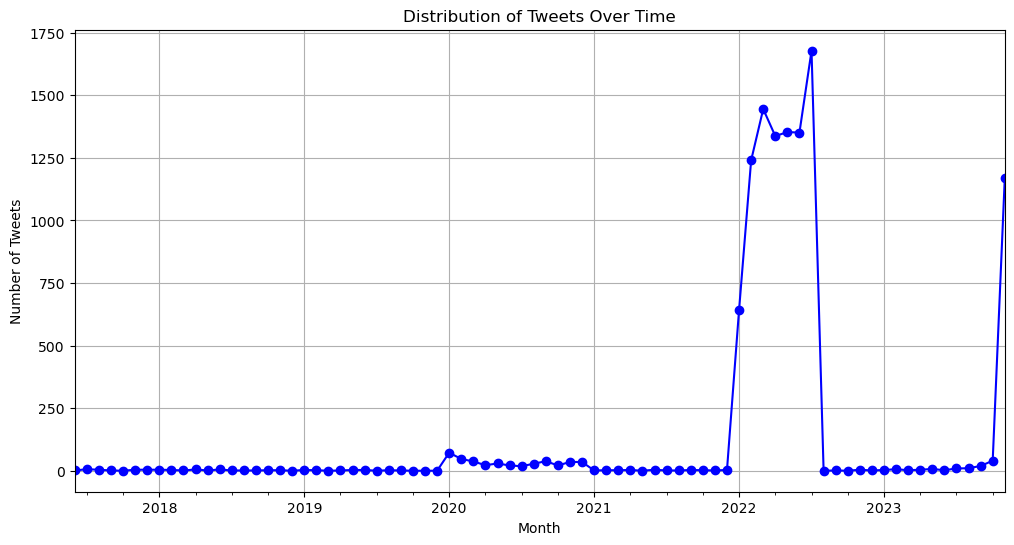

In [5]:
# Temporal Analysis: Distribution of tweets over time
tweets_cleaned.set_index('Time', inplace=True)

# Resampling to get tweet counts per month
monthly_tweets = tweets_cleaned.resample('M').size()

# Plotting
plt.figure(figsize=(12, 6))
monthly_tweets.plot(kind='line', color='blue', marker='o')
plt.title('Distribution of Tweets Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

## User engagement analysis

In [6]:
# Top Engaged Users based on Likes and Retweets
top_users_likes = tweets_cleaned.groupby('UserName')['Likes'].sum().sort_values(ascending=False).head(5)
top_users_retweets = tweets_cleaned.groupby('UserName')['Retweets'].sum().sort_values(ascending=False).head(5)

# Displaying the top engaged users based on likes and retweets
top_engaged_users = {
    "Top Users by Likes": top_users_likes,
    "Top Users by Retweets": top_users_retweets
}

top_engaged_users

{'Top Users by Likes': UserName
 WhipRealer         213000.0
 lifesupremacist    192000.0
 POTUS              189356.0
 NeeNeinNyetNo      174890.0
 AOC                149000.0
 Name: Likes, dtype: float64,
 'Top Users by Retweets': UserName
 POTUS              1512787.0
 lifesupremacist    1166000.0
 AOC                 754000.0
 mchooyah            409000.0
 RBReich             405552.0
 Name: Retweets, dtype: float64}

In [7]:
# Extracting a few of the most liked and retweeted tweets for content analysis
most_liked_tweets_content = tweets_cleaned.loc[tweets_cleaned['Likes'].nlargest(5).index]
most_retweeted_tweets_content = tweets_cleaned.loc[tweets_cleaned['Retweets'].nlargest(5).index]

# Displaying the content of these tweets
most_engaged_tweets_content = {
    "Most Liked Tweets Content": most_liked_tweets_content[['UserName', 'Text', 'Likes']],
    "Most Retweeted Tweets Content": most_retweeted_tweets_content[['UserName', 'Text', 'Retweets']]
}

most_engaged_tweets_content

{'Most Liked Tweets Content':                             UserName  \
 Time                                   
 2022-07-16 14:36:00       WhipRealer   
 2022-07-18 16:10:00  lifesupremacist   
 2022-04-24 22:50:00            POTUS   
 2022-04-23 22:35:00  RyanWil62993886   
 2022-04-23 22:35:00      johnastoehr   
 2022-04-23 22:35:00    NeeNeinNyetNo   
 2022-06-24 21:07:00              AOC   
 
                                                                   Text  \
 Time                                                                     
 2022-07-16 14:36:00  Its a farce Always has been Always will be Cli...   
 2022-07-18 16:10:00  A gathering of white people on colonized land ...   
 2022-04-24 22:50:00  Congratulations to EmmanuelMacron on his reele...   
 2022-04-23 22:35:00  Labor Lap Dog Gilbert allowing Wong to spew li...   
 2022-04-23 22:35:00  This is kind of care we need for climate chang...   
 2022-04-23 22:35:00  Crazy how a guy self immolates in the countrys...   


## Topic Analysis

In [8]:
# Preprocess the Text:

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word not in stop_words and word.isalpha()]

tweets_cleaned['Processed_Text'] = tweets_cleaned['Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/zahra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zahra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Perform LDA Topic Modeling

def perform_lda(text_data, num_topics=5):
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = lda_model.print_topics(num_words=4)
    return topics

# Applying LDA topic modeling
tweets_preprocessed = tweets_cleaned['Processed_Text']
topics = perform_lda(tweets_preprocessed)
topics

[(0,
  '0.012*"climatechange" + 0.009*"climate" + 0.006*"change" + 0.006*"water"'),
 (1, '0.058*"climate" + 0.047*"change" + 0.007*"replying" + 0.005*"us"'),
 (2,
  '0.009*"climatechange" + 0.005*"joe" + 0.003*"manchin" + 0.003*"pacific"'),
 (3, '0.007*"climatechange" + 0.004*"space" + 0.003*"crypto" + 0.003*"gap"'),
 (4,
  '0.023*"climatechange" + 0.017*"help" + 0.016*"emirates" + 0.015*"share"')]

## Sentiment Analysis

In [10]:
# Define the Sentiment Analysis Function
def analyze_sentiment(text):
    """Analyze the sentiment of the given text."""
    if not isinstance(text, str):
        return {"neg": 0, "neu": 0, "pos": 0, "compound": 0}  # Return neutral sentiment for non-string inputs
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

# Apply the Function to the Tweets
tweets_cleaned['Sentiment'] = tweets_cleaned['Text'].apply(analyze_sentiment)

# Display the Results
tweets_cleaned[['Text', 'Sentiment']].head()

,Text,Sentiment
Time,,
2022-01-24 22:24:00,Im glad serious researchers are taking up this...,"{'neg': 0.039, 'neu': 0.7, 'pos': 0.261, 'comp..."
2022-01-24 22:27:00,Partisan adhesion in Canada is weak and partly...,"{'neg': 0.148, 'neu': 0.759, 'pos': 0.094, 'co..."
2022-03-07 23:46:00,Minister Ayers what are you doing to assist th...,"{'neg': 0.055, 'neu': 0.824, 'pos': 0.122, 'co..."
2022-02-22 23:49:00,I want cable news to cover the child poverty r...,"{'neg': 0.179, 'neu': 0.728, 'pos': 0.093, 'co..."
2022-03-21 21:45:00,If we dont adapt the internet to the reality o...,"{'neg': 0.051, 'neu': 0.87, 'pos': 0.078, 'com..."


In [12]:
# Extract the compound sentiment score
tweets_cleaned['Compound_Score'] = tweets_cleaned['Sentiment'].apply(lambda x: x['compound'])

In [13]:
# Ensure 'Time' is set as the index and in datetime format
tweets_cleaned.index = pd.to_datetime(tweets_cleaned.index)

# Resample and calculate the average compound score monthly
monthly_sentiment = tweets_cleaned['Compound_Score'].resample('M').mean()

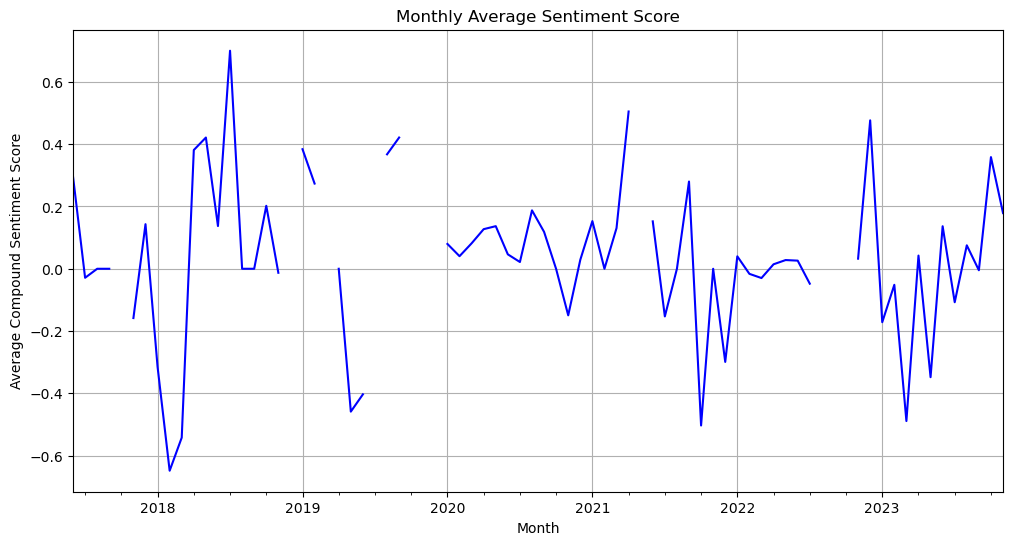

In [14]:
# Plotting the monthly average sentiment score
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', color='blue')
plt.title('Monthly Average Sentiment Score')
plt.xlabel('Month')
plt.ylabel('Average Compound Sentiment Score')
plt.grid(True)
plt.show()

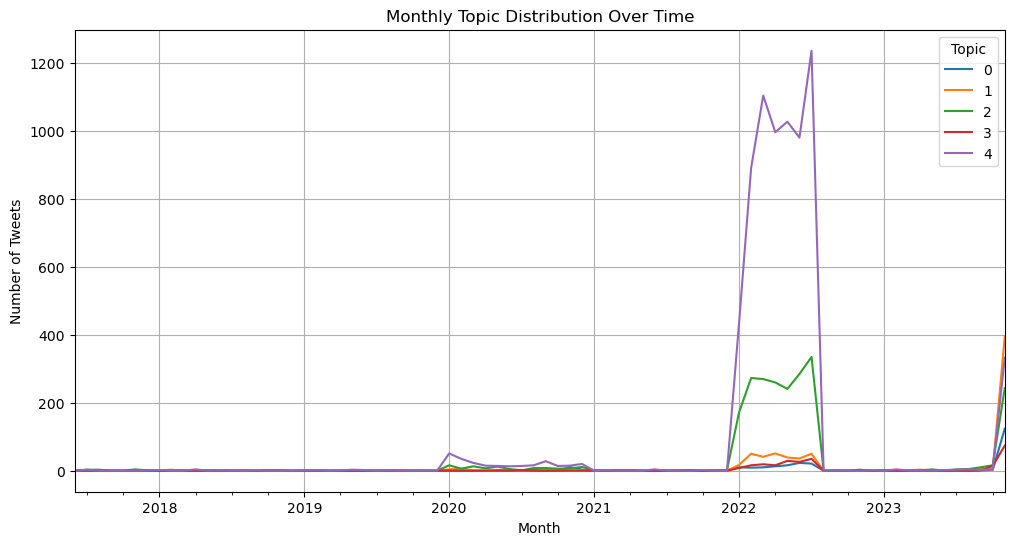

In [15]:
# Create the Document-Term Matrix for LDA analysis
dictionary = corpora.Dictionary(tweets_cleaned['Processed_Text'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tweets_cleaned['Processed_Text']]

# Performing LDA
lda_model = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, passes=15)

def get_dominant_topic(doc_bow):
    """Get the dominant topic for a given document."""
    topic_distribution = lda_model.get_document_topics(doc_bow)
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    return topic_distribution[0][0] if topic_distribution else None

# Assigning dominant topic to each tweet
tweets_cleaned['Topic'] = [get_dominant_topic(doc_bow) for doc_bow in doc_term_matrix]

# Ensure 'Time' is in datetime format and set as index (if not already done)
tweets_cleaned.index = pd.to_datetime(tweets_cleaned.index)

# Counting the number of tweets in each topic per month
monthly_topic_distribution = tweets_cleaned.groupby('Topic').resample('M').size().unstack(fill_value=0)

# Plotting the topic distribution over time
monthly_topic_distribution.T.plot(kind='line', figsize=(12, 6))  # Transpose for proper formatting
plt.title('Monthly Topic Distribution Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.legend(title='Topic')
plt.grid(True)
plt.show()

## Geographical Analysis 

In [16]:
# Checking the contents of the 'City' and 'Country' columns
city_data_preview = tweets_cleaned['City'].value_counts().head()
country_data_preview = tweets_cleaned['Country'].value_counts().head()

# Standardizing country names
tweets_cleaned['Country'] = tweets_cleaned['Country'].replace({'CA': 'Canada', 'NY': 'United States'})

# Handling missing values (if any)
tweets_cleaned['City'].fillna('Unknown', inplace=True)
tweets_cleaned['Country'].fillna('Unknown', inplace=True)

# Aggregating Tweets by Location
city_counts = tweets_cleaned['City'].value_counts()
country_counts = tweets_cleaned['Country'].value_counts()

city_data_preview, country_data_preview, city_counts.head(), country_counts.head()

(New York      290
 Washington    198
 London        180
 Sydney        160
 Melbourne     143
 Name: City, dtype: int64,
 Australia         926
 United Kingdom    639
 Canada            533
 CA                377
 NY                367
 Name: Country, dtype: int64,
 Unknown       7044
 New York       290
 Washington     198
 London         180
 Sydney         160
 Name: City, dtype: int64,
 Unknown           5423
 Australia          926
 Canada             910
 United Kingdom     639
 United States      367
 Name: Country, dtype: int64)

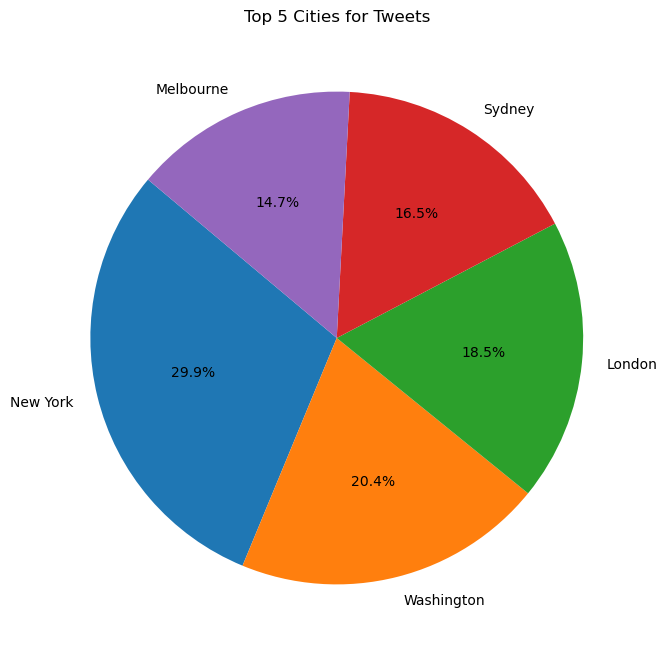

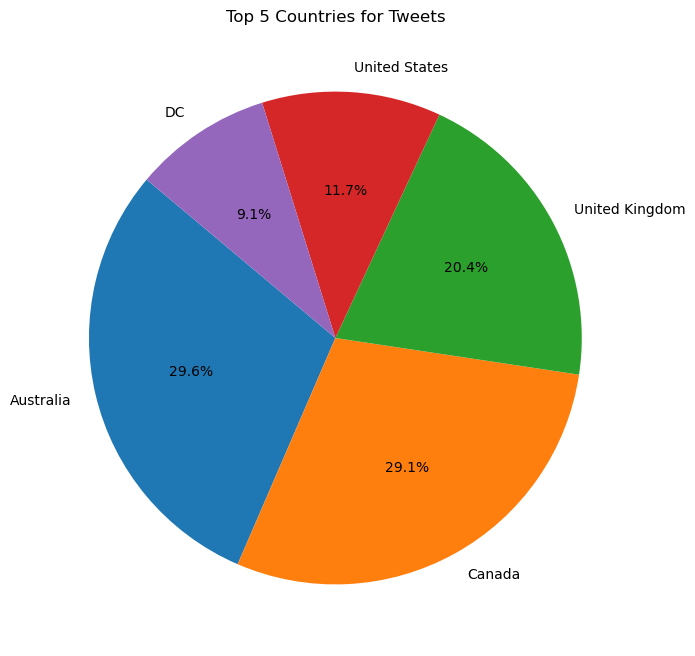

In [17]:
# Check and drop '0' from city_counts if it exists
if '0' in city_counts.index:
    city_counts = city_counts.drop('0')

# Check and drop 'Unknown' from city_counts if it exists
if 'Unknown' in city_counts.index:
    city_counts = city_counts.drop('Unknown')

# Now directly select the top 5 cities
top_cities = city_counts.head(5)

# Similarly, check and drop 'Unknown' from country_counts if it exists
if 'Unknown' in country_counts.index:
    country_counts = country_counts.drop('Unknown')

# Now directly select the top 5 countries
top_countries = country_counts.head(5)

# Proceed with plotting for top cities and countries
plt.figure(figsize=(8, 8))
top_cities.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Cities for Tweets')
plt.ylabel('')  # Hide the y-label

plt.figure(figsize=(8, 8))
top_countries.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Countries for Tweets')
plt.ylabel('')  # Hide the y-label

plt.show()

In [18]:
# ???????should we include unknown???????

In [10]:
# Inspect Location Data, Checking the contents of the 'City' and 'Country' columns

city_data_preview = tweets_cleaned['City'].value_counts().head()
country_data_preview = tweets_cleaned['Country'].value_counts().head()

city_data_preview, country_data_preview

(New York      290
 Washington    198
 London        180
 Sydney        160
 Melbourne     143
 Name: City, dtype: int64,
 Australia         926
 United Kingdom    639
 Canada            533
 CA                377
 NY                367
 Name: Country, dtype: int64)

In [11]:
# Standardizing country names
tweets_cleaned['Country'] = tweets_cleaned['Country'].replace({'CA': 'Canada', 'NY': 'United States'})

# Handling missing values (if any)
tweets_cleaned['City'].fillna('Unknown', inplace=True)
tweets_cleaned['Country'].fillna('Unknown', inplace=True)

In [12]:
# Aggregating Tweets by Location

city_counts = tweets_cleaned['City'].value_counts()
country_counts = tweets_cleaned['Country'].value_counts()

print("Top Cities for Climate Change Tweets:")
print(city_counts.head())  # Display top 5 cities

print("\nTop Countries for Climate Change Tweets:")
print(country_counts.head())  # Display top 5 countries

Top Cities for Climate Change Tweets:
Unknown       7044
New York       290
Washington     198
London         180
Sydney         160
Name: City, dtype: int64

Top Countries for Climate Change Tweets:
Unknown           5423
Australia          926
Canada             910
United Kingdom     639
United States      367
Name: Country, dtype: int64


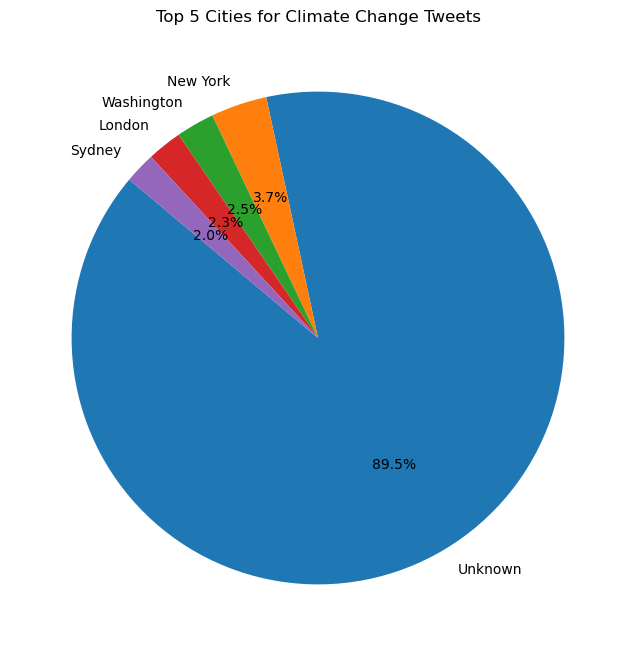

In [14]:
# Visualization
# Selecting the top 5 cities
top_cities = tweets_cleaned['City'].value_counts().head(5)

# Plotting
top_cities.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title('Top 5 Cities for Climate Change Tweets')
plt.ylabel('')  # Hide the y-label
plt.show()

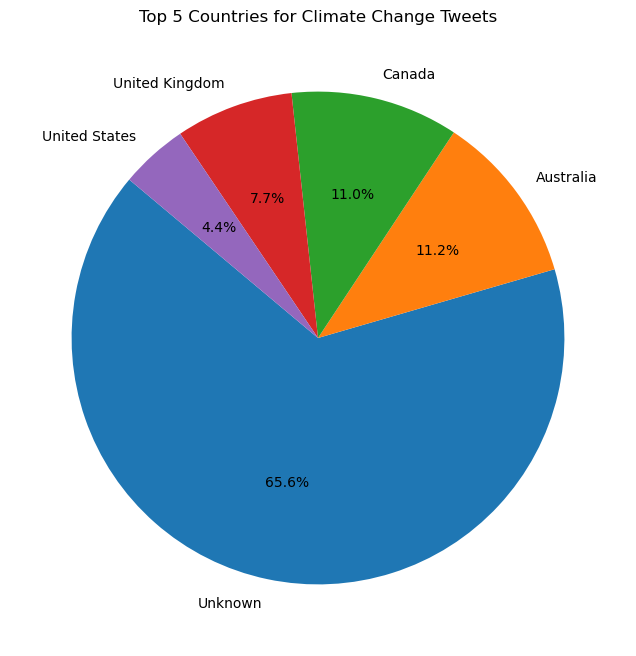

In [15]:
# Selecting the top 5 countries
top_countries = tweets_cleaned['Country'].value_counts().head(5)

# Plotting
top_countries.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title('Top 5 Countries for Climate Change Tweets')
plt.ylabel('')  # Hide the y-label
plt.show()

## Next network Analysis of User Interactions